# Desafio Grupo Zap Data Science
### O objetivo do desafio estimar um preço de venda para os apartamentos no dataset de teste.

# Importando libs

In [105]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.6f}'.format

# Importando os dados de treino e teste

#### Abrindo o arquivo .json e lendo as linhas, pois cada objeto json está em uma linha. Assim teremos todos os objetos em forma de string, e precisamos iteralos para transformar cada linha de objeto em um dict através do json.loads. Utilizar o json_normalize do pandas para criar um dataframe com propriedades de dados aninhados.

In [106]:
# função responsável por ler um json, e normalizá-lo quando tem objetos aninhados.
def read_normalize_json(file_path):
    with open(file_path) as f:
        data = f.readlines()

    for i in range(len(data)):
        data[i] = json.loads(data[i])
        
    return pd.json_normalize(data)

    
df_train = read_normalize_json('source-4-ds-train.json')
df_test = read_normalize_json('source-4-ds-test.json')

In [107]:
df_train.head()

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,suites,publicationType,bathrooms,totalAreas,bedrooms,address.country,address.zipCode,address.city,address.streetNumber,address.zone,address.geoLocation.precision,address.geoLocation.location.lon,address.geoLocation.location.lat,address.street,address.locationId,address.district,address.unitNumber,address.state,address.neighborhood,pricingInfos.price,pricingInfos.businessType,pricingInfos.period,pricingInfos.yearlyIptu,pricingInfos.rentalTotalPrice,pricingInfos.monthlyCondoFee
0,388.000000,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,2017-02-07T13:21:40Z,f4603b2b52,TWO_STORY_HOUSE,ACTIVE,787c7bd19d,6.000000,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.000000,STANDARD,3.000000,388.000000,4.000000,BR,04290030,São Paulo,53,Zona Sul,ROOFTOP,-46.614222,-23.612923,Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,Jardim da Saúde,700000,SALE,NaN,nan,nan,nan
1,129.000000,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,2016-03-21T18:35:17Z,f4603b2b52,HOME,ACTIVE,4d68c0cdbe,2.000000,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.000000,STANDARD,2.000000,129.000000,3.000000,BR,04187320,São Paulo,16,Zona Sul,RANGE_INTERPOLATED,-46.593475,-23.643962,Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,São Paulo,Vila Santa Teresa (Zona Sul),336000,SALE,NaN,nan,nan,nan
2,396.000000,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.000000,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,0.000000,STANDARD,4.000000,nan,0.000000,,01311000,São Paulo,402,,ROOFTOP,-46.647452,-23.568559,Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,São Paulo,Bela Vista,24929,RENTAL,MONTHLY,"4,040.000000","29,829.000000","4,900.000000"
3,80.000000,"Viva melhor e de um jeito novo, com privilégio...","Apartamento com 80m², 2 vagas próximo ao Parqu...",2018-10-26T16:18:28.915Z,527c7b0cc0,APARTMENT,ACTIVE,6654d93423,2.000000,2018-11-08T16:38:35.434Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,1.000000,STANDARD,2.000000,80.000000,3.000000,,04550004,São Paulo,1190,,RANGE_INTERPOLATED,-46.682781,-23.598023,Rua Alvorada,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,,,São Paulo,Vila Olímpia,739643,SALE,NaN,"1,610.000000",nan,686.000000
4,"3,322.000000",Sua área é ocupada majoritariamente por instit...,"Apartamento 332m², 4 suítes à venda próximo ao...",2018-12-14T18:06:51.342Z,527c7b0cc0,APARTMENT,ACTIVE,9ffaf676ae,5.000000,2018-12-14T18:06:55.140Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,4.000000,STANDARD,5.000000,332.000000,4.000000,,04005030,São Paulo,380,,RANGE_INTERPOLATED,-46.653027,-23.582497,Rua Curitiba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,,,São Paulo,Paraíso,7520099,SALE,NaN,"18,900.000000",nan,"6,230.000000"


In [108]:
df_test.head()

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,suites,publicationType,bathrooms,totalAreas,bedrooms,address.country,address.zipCode,address.city,address.streetNumber,address.zone,address.geoLocation.precision,address.geoLocation.location.lon,address.geoLocation.location.lat,address.street,address.locationId,address.district,address.unitNumber,address.state,address.neighborhood,pricingInfos.price,pricingInfos.businessType,pricingInfos.yearlyIptu,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.rentalTotalPrice
0,47.000000,Apartamentos de 1 dormitório na Rua Bela Cintr...,Apartamento Bela Cintra,2015-10-20T20:52:41Z,967d57ce20,APARTMENT,ACTIVE,89224365f8,1.000000,2018-11-08T15:02:53.953Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,0.000000,STANDARD,1.000000,47.000000,1,BR,01415000,São Paulo,,Centro,GEOMETRIC_CENTER,-46.662765,-23.557225,Rua Bela Cintra,BR>Sao Paulo>NULL>Sao Paulo>Centro>Consolacao,,,São Paulo,Consolação,None,SALE,nan,nan,NaN,nan
1,55.000000,"Ótima localização, próximo ao shopping Central...","Apartamento residencial à venda, Quinta da Pai...",2018-07-31T06:10:07.427Z,bddebf057a,APARTMENT,ACTIVE,363731333f,1.000000,2018-11-08T16:10:49.374Z,False,[http://images.ingaiasites.com.br/AolwiwJLLpET...,0.000000,STANDARD,0.000000,55.000000,2,BR,03152155,São Paulo,100,Zona Leste,ROOFTOP,-46.581879,-23.592852,Rua Bruno Cavalcanti Feder,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Quinta ...,,,São Paulo,Quinta da Paineira,None,SALE,0.000000,0.000000,NaN,nan
2,92.000000,Apartamento maravilhoso com ampla sala ( abriu...,"Apartamento em Santa Terezinha - São Paulo, SP",2018-01-25T13:57:14.203Z,d7190e8f4c,APARTMENT,ACTIVE,6e6283378a,2.000000,2019-02-12T18:29:26.933Z,False,[https://ssl-w08cnn0135.websiteseguro.com/mira...,1.000000,STANDARD,3.000000,nan,3,,02461000,São Paulo,313,,ROOFTOP,-46.638456,-23.493609,Rua Copacabana,BR>Sao Paulo>NULL>Sao Paulo>Zona Norte>Santa T...,,,São Paulo,Chora Menino,None,SALE,nan,686.000000,NaN,nan
3,145.000000,"Apartamento residencial à venda, Brooklin Paul...",Apartamento reformado com varanda gourmet no B...,2018-04-27T11:33:34.096Z,316d75f06f,APARTMENT,ACTIVE,4c29a27f44,3.000000,2019-02-24T23:34:29.306Z,False,[http://images.ingaiasites.com.br/3hLtXgzu4KQj...,3.000000,STANDARD,4.000000,145.000000,3,,04561003,São Paulo,,,GEOMETRIC_CENTER,-46.686180,-23.607981,Rua Guararapes,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Brooklin,,,São Paulo,Brooklin Paulista,None,SALE,368.000000,770.000000,NaN,nan
4,76.000000,,"Apartamento Residencial à venda, Alto de Pinhe...",2018-09-16T00:58:01.666Z,295eddde1a,APARTMENT,ACTIVE,7b16cf224b,1.000000,2019-02-23T00:33:46.237Z,False,[http://cdn1.valuegaia.com.br/watermark/agenci...,1.000000,STANDARD,2.000000,76.000000,2,,05468140,São Paulo,2174,,ROOFTOP,-46.715088,-23.540604,Rua Pio XI,BR>Sao Paulo>NULL>Sao Paulo>Zona Oeste>Alto de...,,,São Paulo,Alto de Pinheiros,None,SALE,79.000000,472.000000,NaN,nan


# Análise dos dados

## Análise da variável price

In [109]:
df_train['pricingInfos.price'].describe()

count      133,964.000000
mean       663,748.351811
std      1,317,731.679053
min             70.000000
25%        175,000.000000
50%        371,000.000000
75%        700,000.000000
max     84,000,000.000000
Name: pricingInfos.price, dtype: float64

/media/will/0DFC376810E8A43F/DataScience/GrupoZap-DataScienceChallenge/env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


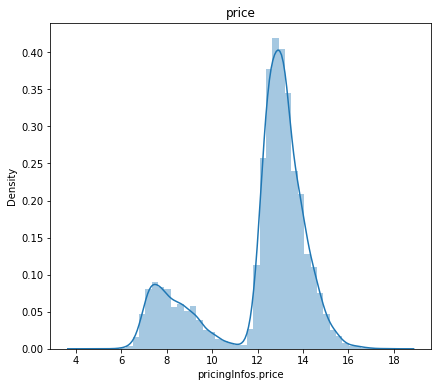

In [110]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('price')
sns.distplot(np.log1p(df_train['pricingInfos.price']), ax=ax)
plt.show()

#### Correlações dos dados númericos

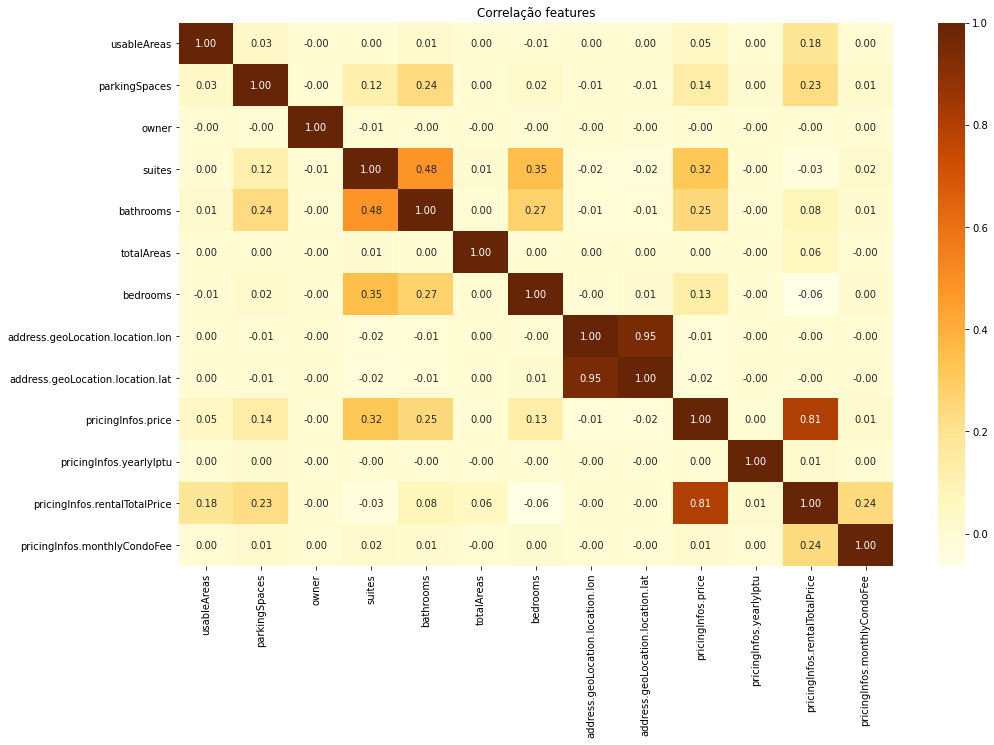

In [111]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train.corr(), annot=True, cmap='YlOrBr', fmt=".2f")
plt.title('Correlação features')
plt.show()

#### Correlação em relação ao preço do imóvel

In [112]:
train_corr = df_train.corr()
train_corr['pricingInfos.price'].sort_values(ascending=False).to_frame().style.background_gradient(cmap=sns.color_palette('YlOrBr', as_cmap=True))

,pricingInfos.price
pricingInfos.price,1.000000
pricingInfos.rentalTotalPrice,0.806321
suites,0.321463
bathrooms,0.245185
parkingSpaces,0.135957
bedrooms,0.132376
usableAreas,0.045574
pricingInfos.monthlyCondoFee,0.013627
totalAreas,0.002014
pricingInfos.yearlyIptu,0.000206


#### Através da análise, é possível ver que possuem outliers que podem ser um problema para o modelo. Porém, vamos tratá-los depois.

## Análise da base de testes e treino

In [113]:
print('Shape treino: ', df_train.shape)
print('Shape teste: ', df_test.shape)

Shape treino:  (133964, 37)
Shape teste:  (16036, 37)


In [114]:
df_train.describe()

,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,address.geoLocation.location.lon,address.geoLocation.location.lat,pricingInfos.price,pricingInfos.yearlyIptu,pricingInfos.rentalTotalPrice,pricingInfos.monthlyCondoFee
count,"133,211.000000","129,539.000000","120,347.000000","133,051.000000","91,132.000000","130,945.000000","133,953.000000","133,953.000000","133,964.000000","114,612.000000","28,714.000000","117,127.000000"
mean,220.483226,2.443187,1.106534,2.375683,"13,270.587445",2.327023,-46.643395,-23.554263,"663,748.351811","4,182.520076","11,021.829874","1,507.678520"
std,"5,713.502066",5.251624,1.218938,2.146044,"3,682,657.704269",2.140123,0.318494,0.165147,"1,317,731.679053","850,109.115348","77,012.229803","77,954.055478"
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.820973,-23.848153,70.000000,0.000000,0.000000,0.000000
25%,60.000000,1.000000,0.000000,1.000000,60.000000,2.000000,-46.684151,-23.594475,"175,000.000000",0.000000,"2,310.000000",0.000000
50%,105.000000,2.000000,1.000000,2.000000,120.000000,2.000000,-46.654071,-23.558990,"371,000.000000",84.000000,"4,111.500000",399.000000
75%,200.000000,3.000000,2.000000,3.000000,250.000000,3.000000,-46.607885,-23.527634,"700,000.000000",364.000000,"9,100.000000",861.000000
max,"2,025,000.000000",589.000000,80.000000,200.000000,"1,111,111,111.000000",600.000000,0.000000,0.000000,"84,000,000.000000","283,024,210.000000","11,900,000.000000","24,430,000.000000"


In [115]:
df_test.describe()

,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,address.geoLocation.location.lon,address.geoLocation.location.lat,pricingInfos.yearlyIptu,pricingInfos.monthlyCondoFee,pricingInfos.rentalTotalPrice
count,"16,029.000000","15,772.000000","14,641.000000","16,035.000000","9,942.000000","16,036.000000","16,033.000000","16,033.000000","13,639.000000","15,100.000000",14.000000
mean,116.448250,1.739538,1.172324,2.257187,252.474754,2.581754,-46.642554,-23.558230,"5,794.045531","1,470.143377",183.500000
std,565.485325,1.146988,1.125591,1.670712,"6,764.673783",0.976679,0.524534,0.267507,"599,528.359472","37,617.894154",686.594130
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.803329,-23.744563,0.000000,0.000000,0.000000
25%,59.000000,1.000000,0.000000,1.000000,56.000000,2.000000,-46.683541,-23.599426,0.000000,278.000000,0.000000
50%,80.000000,1.000000,1.000000,2.000000,85.000000,3.000000,-46.653328,-23.560475,70.000000,475.000000,0.000000
75%,136.000000,2.000000,2.000000,3.000000,160.000000,3.000000,-46.615534,-23.538932,308.000000,875.000000,0.000000
max,"70,600.000000",20.000000,5.000000,99.000000,"665,420.000000",54.000000,0.000000,0.000000,"70,000,000.000000","3,072,300.000000","2,569.000000"


#### Através do describe já podemos ver que existem diversos outliers, porém vamos tratar depois.

In [116]:
df_test.describe(include=[np.object, np.bool]).T

,count,unique,top,freq
description,16036,15160,,312
title,16036,11638,Apartamento em São Paulo,305
createdAt,16036,16010,2015-09-01T13:45:18Z,3
publisherId,16036,1817,a8b38b03a8,430
unitTypes,16036,1,APARTMENT,16036
listingStatus,16036,1,ACTIVE,16036
id,16036,16036,11ad9685bc,1
updatedAt,15338,14079,2018-11-08T13:49:39.008Z,69
owner,16036,2,False,16033
images,16036,15936,[https://s3.amazonaws.com/uploaded.prod.corret...,7


#### Aqui podemos ver que todos os dados de teste são do tipo unitTypes APARTMENT, todos são do tipo SALE, e de São Paulo.

#### Vamos filtrar os dados de teste para que sejam apenas desse tipo

In [117]:
print(df_train['unitTypes'].value_counts())

APARTMENT                     72241
TWO_STORY_HOUSE               18068
HOME                           9030
OFFICE                         7714
FLAT                           7661
COMMERCIAL_PROPERTY            5871
CONDOMINIUM                    4015
PENTHOUSE                      2772
SHED_DEPOSIT_WAREHOUSE         2197
RESIDENTIAL_ALLOTMENT_LAND     1430
COMMERCIAL_ALLOTMENT_LAND       807
STORE                           694
BUSINESS                        663
KITNET                          522
RESIDENTIAL_BUILDING            142
COMMERCIAL_BUILDING              85
CLINIC                           33
FARM                             10
COUNTRY_HOUSE                     9
Name: unitTypes, dtype: int64


#### Filtrando apenas pelo tipo de APARTMENT e deletando a coluna.

In [118]:
df_train = df_train[df_train['unitTypes'] == 'APARTMENT']
df_train = df_train.reset_index(drop=True)
df_train = df_train.drop(['unitTypes'], axis=1)
df_test = df_test.drop(['unitTypes'], axis=1)

#### Agora fazer o mesmo para businessType tipo SALE

In [119]:
print(df_train['pricingInfos.businessType'].value_counts())

SALE      64146
RENTAL     8095
Name: pricingInfos.businessType, dtype: int64


In [120]:
df_train = df_train[df_train['pricingInfos.businessType'] == 'SALE']
df_train = df_train.reset_index(drop=True)
df_train = df_train.drop(['pricingInfos.businessType'], axis=1)
df_test = df_test.drop(['pricingInfos.businessType'], axis=1)

### Irei remover algumas colunas que considero não úteis para essa análise.

In [121]:
df_train = df_train.drop(['description', 'title', 'createdAt', 
                                      'publisherId', 'listingStatus', 'id', 'publicationType',
                                      'updatedAt','owner', 'images', 'address.country', 'address.zipCode', 'address.city',
                                      'address.streetNumber', 'address.zone', 'address.street', 'address.locationId', 'address.district',
                                      'address.unitNumber', 'address.state', 'pricingInfos.rentalTotalPrice',
                                      'pricingInfos.period','address.geoLocation.location.lat','address.geoLocation.location.lon', 'address.geoLocation.precision'],axis = 1)
df_train = df_train.reset_index(drop=True)
df_test = df_test.drop(['description', 'title', 'createdAt', 
                                      'publisherId', 'listingStatus', 'id', 'publicationType',
                                      'updatedAt','owner', 'images', 'address.country', 'address.zipCode', 'address.city',
                                      'address.streetNumber', 'address.zone', 'address.street', 'address.locationId', 'address.district',
                                      'address.unitNumber', 'address.state', 'pricingInfos.rentalTotalPrice',
                                      'pricingInfos.period','address.geoLocation.location.lat','address.geoLocation.location.lon', 'address.geoLocation.precision'],axis = 1)
df_test = df_test.reset_index(drop=True)

## Verificando e tratando valores nulos

### Base de treino

In [124]:
print('Valores nulos em porcentagem: \n{}'.format((df_train.isnull().mean() * 100).sort_values(ascending=False)))
print('\nValores nulos em quantidade: \n{}'.format((df_train.isnull().sum()).sort_values(ascending=False)))

Valores nulos em porcentagem: 
totalAreas                     38.904998
pricingInfos.yearlyIptu        14.945593
suites                          8.786206
pricingInfos.monthlyCondoFee    5.658965
parkingSpaces                   1.758488
usableAreas                     0.012472
bathrooms                       0.001559
pricingInfos.price              0.000000
address.neighborhood            0.000000
bedrooms                        0.000000
dtype: float64

Valores nulos em quantidade: 
totalAreas                      24956
pricingInfos.yearlyIptu          9587
suites                           5636
pricingInfos.monthlyCondoFee     3630
parkingSpaces                    1128
usableAreas                         8
bathrooms                           1
pricingInfos.price                  0
address.neighborhood                0
bedrooms                            0
dtype: int64


### Base de teste

In [125]:
print('Valores nulos em porcentagem: \n{}'.format((df_test.isnull().mean() * 100).sort_values(ascending=False)))
print('\nValores nulos em quantidade: \n{}'.format((df_test.isnull().sum()).sort_values(ascending=False)))

Valores nulos em porcentagem: 
pricingInfos.price             100.000000
totalAreas                      38.001996
pricingInfos.yearlyIptu         14.947618
suites                           8.699177
pricingInfos.monthlyCondoFee     5.836867
parkingSpaces                    1.646296
usableAreas                      0.043652
bathrooms                        0.006236
address.neighborhood             0.000000
bedrooms                         0.000000
dtype: float64

Valores nulos em quantidade: 
pricingInfos.price              16036
totalAreas                       6094
pricingInfos.yearlyIptu          2397
suites                           1395
pricingInfos.monthlyCondoFee      936
parkingSpaces                     264
usableAreas                         7
bathrooms                           1
address.neighborhood                0
bedrooms                            0
dtype: int64


In [126]:
df_test = df_test.drop(['pricingInfos.price'], axis = 1)

### Preenchendo os valores nulos utilizando o método MICE.

In [127]:
from feature_engine import missing_data_imputers  as msi

fill_columns = ['totalAreas', 'pricingInfos.yearlyIptu', 'pricingInfos.monthlyCondoFee', 'suites', 'parkingSpaces',
               'bedrooms', 'usableAreas', 'bathrooms']

addBinary_imputer = msi.AddMissingIndicator(variables=fill_columns)
addBinary_imputer.fit(df_train)
addBinary_imputer_test = msi.AddMissingIndicator(variables =fill_columns )
addBinary_imputer_test.fit(df_test)
df_train = addBinary_imputer.transform(df_train)
df_test = addBinary_imputer_test.transform(df_test)

### Como já foi marcado os valores que possuem nulos, podemos preencher com 0 os valores nulos.

In [128]:
fill_columns = ['totalAreas', 'pricingInfos.yearlyIptu', 'pricingInfos.monthlyCondoFee', 'suites', 'parkingSpaces',
               'bedrooms', 'usableAreas', 'bathrooms']

for col in fill_columns:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

In [129]:
print('Valores nulos em porcentagem: \n{}'.format((df_train.isnull().mean() * 100).sort_values(ascending=False)))
print('\nValores nulos em quantidade: \n{}'.format((df_train.isnull().sum()).sort_values(ascending=False)))

Valores nulos em porcentagem: 
bathrooms_na                      0.000000
pricingInfos.price                0.000000
parkingSpaces                     0.000000
suites                            0.000000
bathrooms                         0.000000
totalAreas                        0.000000
bedrooms                          0.000000
address.neighborhood              0.000000
pricingInfos.yearlyIptu           0.000000
usableAreas_na                    0.000000
pricingInfos.monthlyCondoFee      0.000000
totalAreas_na                     0.000000
pricingInfos.yearlyIptu_na        0.000000
pricingInfos.monthlyCondoFee_na   0.000000
suites_na                         0.000000
parkingSpaces_na                  0.000000
usableAreas                       0.000000
dtype: float64

Valores nulos em quantidade: 
bathrooms_na                       0
pricingInfos.price                 0
parkingSpaces                      0
suites                             0
bathrooms                          0
totalAr

In [130]:
print('Valores nulos em porcentagem: \n{}'.format((df_test.isnull().mean() * 100).sort_values(ascending=False)))
print('\nValores nulos em quantidade: \n{}'.format((df_test.isnull().sum()).sort_values(ascending=False)))

Valores nulos em porcentagem: 
bathrooms_na                      0.000000
usableAreas_na                    0.000000
parkingSpaces_na                  0.000000
suites_na                         0.000000
pricingInfos.monthlyCondoFee_na   0.000000
pricingInfos.yearlyIptu_na        0.000000
totalAreas_na                     0.000000
pricingInfos.monthlyCondoFee      0.000000
pricingInfos.yearlyIptu           0.000000
address.neighborhood              0.000000
bedrooms                          0.000000
totalAreas                        0.000000
bathrooms                         0.000000
suites                            0.000000
parkingSpaces                     0.000000
usableAreas                       0.000000
dtype: float64

Valores nulos em quantidade: 
bathrooms_na                       0
usableAreas_na                     0
parkingSpaces_na                   0
suites_na                          0
pricingInfos.monthlyCondoFee_na    0
pricingInfos.yearlyIptu_na         0
totalAreas_na

## Tratamento dos dados

### Tratando outliers

#### Para tratar os outliers de algumas features, vou utilizar Amplitute Interquartil. É uma abordagem geral que calcula as quantis e as faixas de interquantilidade.
#### E alguns dados mais sensíveis irei tratar manualmente.

In [131]:
def outlier_detection(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (3 * IQR)
    upper_range = Q3 + (3 * IQR)
    print(lower_range)
    print(upper_range)
    dataset = dataset.drop(dataset[(dataset[column] > upper_range) | (dataset[column] < lower_range)].index)
    dataset = dataset.reset_index(drop=True)
    return dataset

def outlier_detection_nodrop(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (3 * IQR)
    upper_range = Q3 + (3 * IQR)
    print(lower_range)
    print(upper_range)

### Bedrooms

In [132]:
df_train['bedrooms'].describe()

count   64,146.000000
mean         2.577105
std          0.846769
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         30.000000
Name: bedrooms, dtype: float64

#### Gráfico de bedrooms em relação ao preço antes e de pois da aplitude interquartil

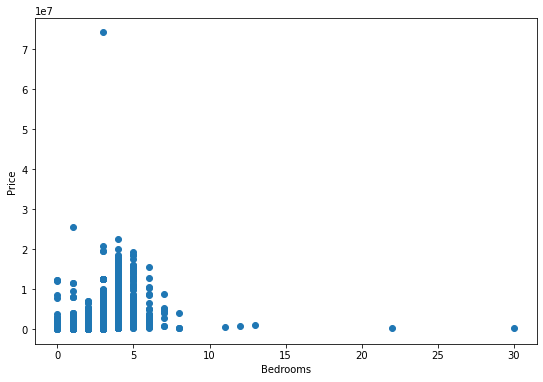

In [133]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['bedrooms'],df_train['pricingInfos.price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

-1.0
6.0


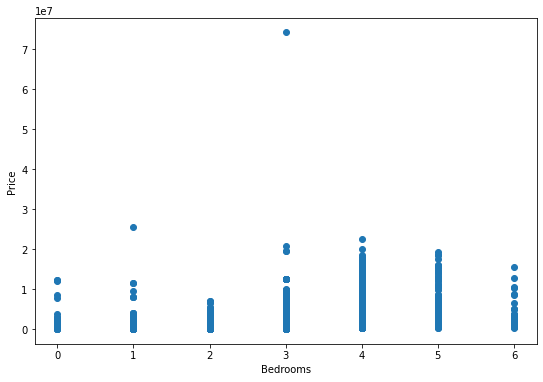

In [134]:
df_train = outlier_detection(df_train, 'bedrooms')

plt.figure(figsize=(9,6))
plt.scatter(df_train['bedrooms'],df_train['pricingInfos.price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

### Bathrooms

#### Gráfico de Bathrooms em relação ao preço antes e de pois da aplitude interquartil

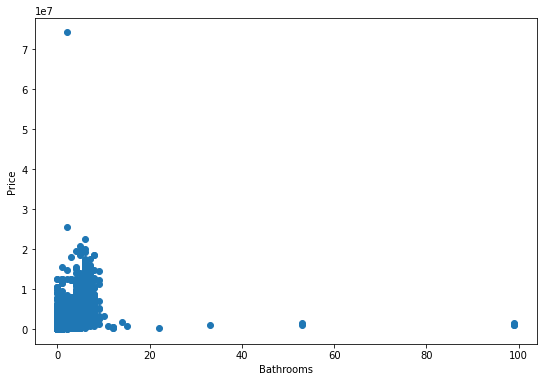

In [135]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['bathrooms'],df_train['pricingInfos.price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.show()

-5.0
9.0


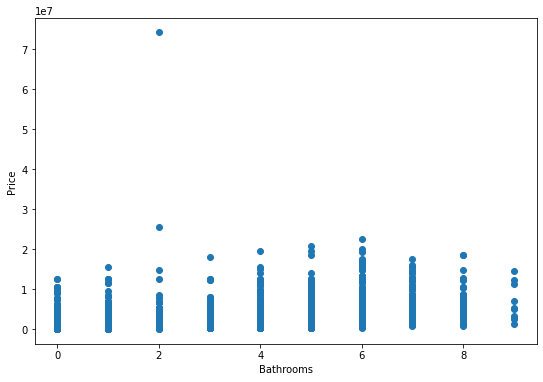

In [136]:
df_train = outlier_detection(df_train, 'bathrooms')

plt.figure(figsize=(9,6))
plt.scatter(df_train['bathrooms'],df_train['pricingInfos.price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.show()

### Suites

#### Gráfico de Suites em relação ao preço antes e de pois da aplitude interquartil

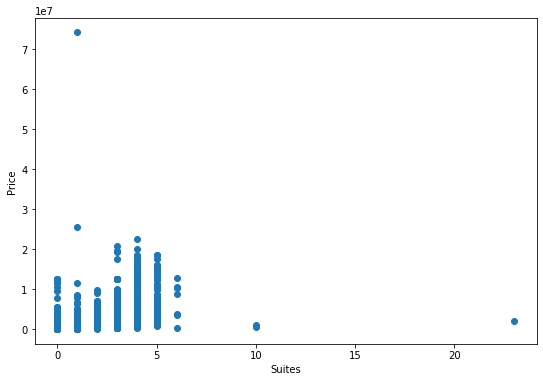

In [137]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['suites'],df_train['pricingInfos.price'])
plt.xlabel('Suites')
plt.ylabel('Price')
plt.show()

-3.0
4.0


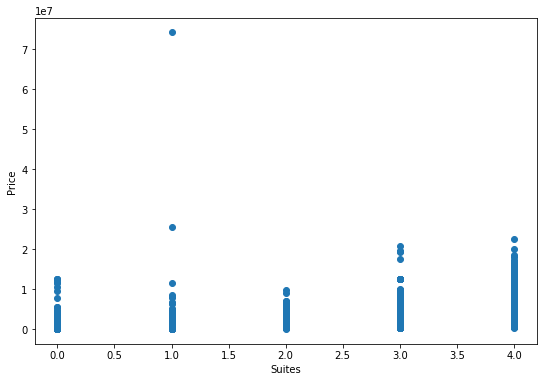

In [138]:
df_train = outlier_detection(df_train, 'suites')

plt.figure(figsize=(9,6))
plt.scatter(df_train['suites'],df_train['pricingInfos.price'])
plt.xlabel('Suites')
plt.ylabel('Price')
plt.show()

### Monthly Condo Fee
#### Gráfico de Monthly Condo Fee em relação ao preço antes e de pois da aplitude interquartil

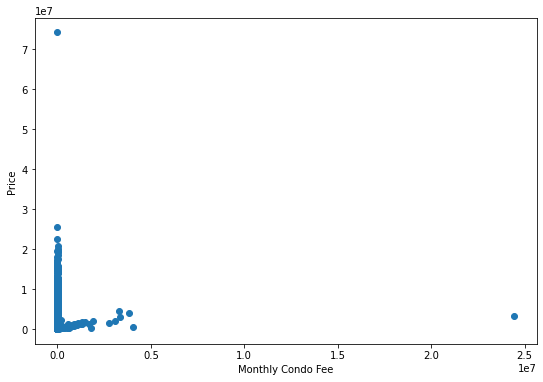

In [139]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.monthlyCondoFee'],df_train['pricingInfos.price'])
plt.xlabel('Monthly Condo Fee')
plt.ylabel('Price')
plt.show()

-1544.0
2628.0


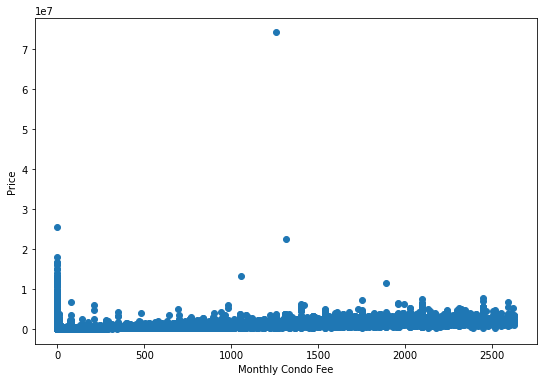

In [140]:
df_train = outlier_detection(df_train, 'pricingInfos.monthlyCondoFee')

plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.monthlyCondoFee'],df_train['pricingInfos.price'])
plt.xlabel('Monthly Condo Fee')
plt.ylabel('Price')
plt.show()

### Price

In [141]:
df_train['pricingInfos.price'].describe()

count       62,078.000000
mean       664,726.895599
std        762,449.467170
min         10,500.000000
25%        269,500.000000
50%        455,000.000000
75%        805,000.000000
max     74,200,000.000000
Name: pricingInfos.price, dtype: float64

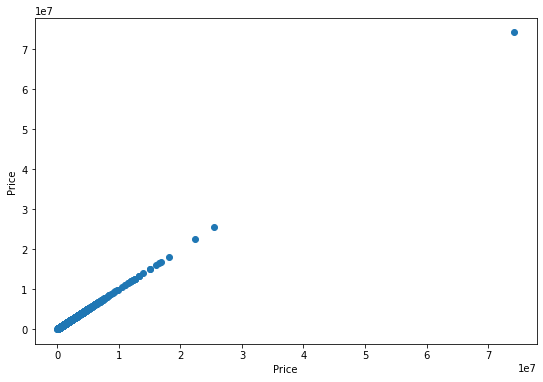

In [142]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.price'],df_train['pricingInfos.price'])
plt.xlabel('Price')
plt.ylabel('Price')
plt.show()

-1337000.0
2411500.0


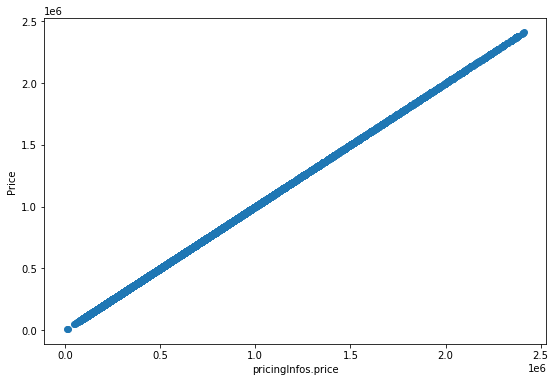

In [143]:
df_train = outlier_detection(df_train, 'pricingInfos.price')

plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.price'],df_train['pricingInfos.price'])
plt.xlabel('pricingInfos.price')
plt.ylabel('Price')
plt.show()

### Parking Spaces

In [144]:
df_train['parkingSpaces'].describe()

count   60,571.000000
mean         1.581648
std          1.349744
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        215.000000
Name: parkingSpaces, dtype: float64

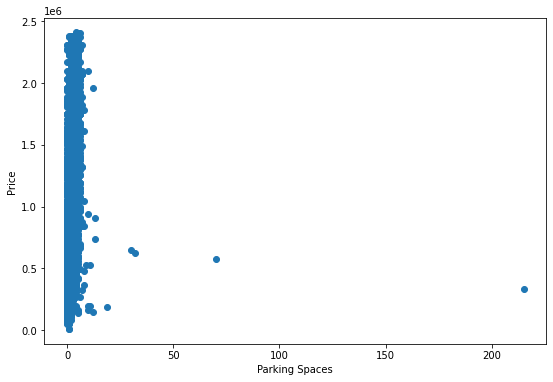

In [145]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['parkingSpaces'],df_train['pricingInfos.price'])
plt.xlabel('Parking Spaces')
plt.ylabel('Price')
plt.show()

#### Utilizando a função para detectar os limites da amplitude interquartil, como pareceu um pouco baixo, resolvi tratar manualmente

In [146]:
outlier_detection_nodrop(df_train, 'parkingSpaces')

-2.0
5.0


<AxesSubplot:xlabel='parkingSpaces'>

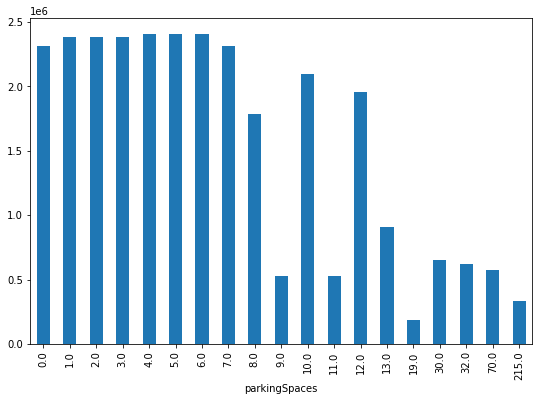

In [147]:
df_train.groupby('parkingSpaces')['pricingInfos.price'].max().plot.bar(figsize=(9,6))

In [148]:
df_train = df_train[df_train['parkingSpaces'] <= 20]

### Usable Areas

In [149]:
df_train['usableAreas'].describe()

count    60,567.000000
mean        103.369409
std         647.017689
min           0.000000
25%          58.000000
50%          78.000000
75%         124.000000
max     129,000.000000
Name: usableAreas, dtype: float64

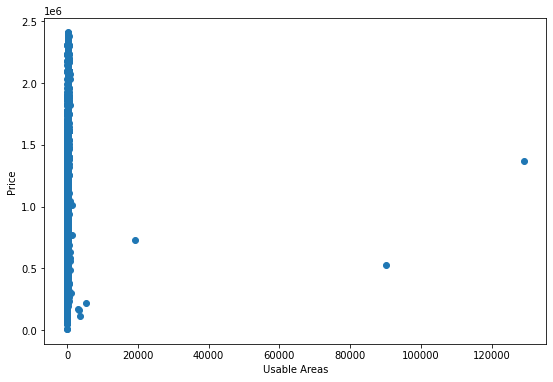

In [150]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['usableAreas'],df_train['pricingInfos.price'])
plt.xlabel('Usable Areas')
plt.ylabel('Price')
plt.show()

In [151]:
outlier_detection_nodrop(df_train, 'usableAreas')

-140.0
322.0


-140.0
322.0


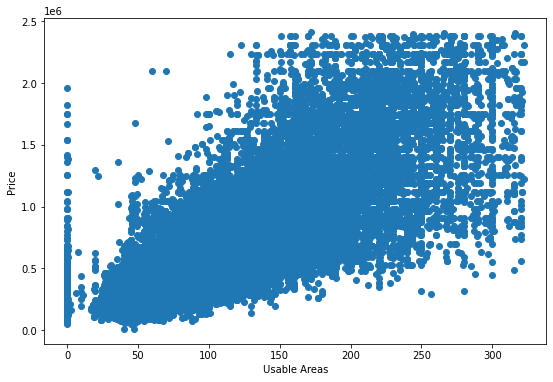

In [152]:
df_train = outlier_detection(df_train, 'usableAreas')

plt.figure(figsize=(9,6))
plt.scatter(df_train['usableAreas'],df_train['pricingInfos.price'])
plt.xlabel('Usable Areas')
plt.ylabel('Price')
plt.show()

### Yearly IPTU

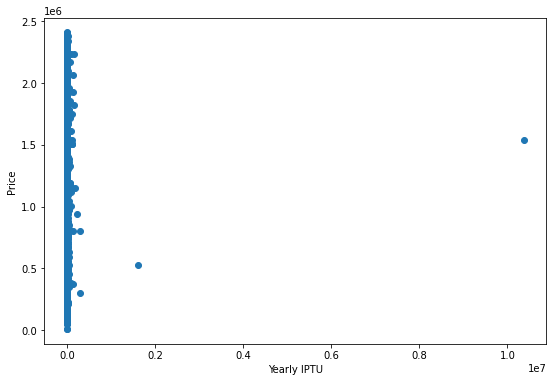

In [153]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.yearlyIptu'],df_train['pricingInfos.price'])
plt.xlabel('Yearly IPTU')
plt.ylabel('Price')
plt.show()

-609.0
812.0


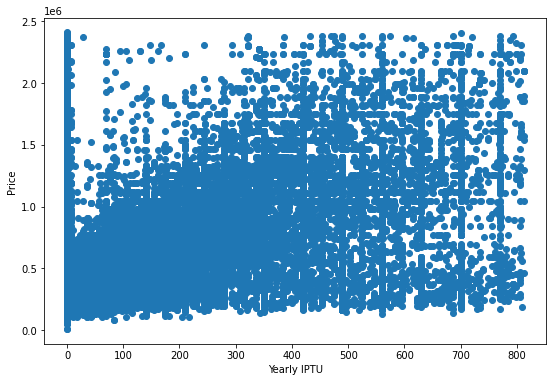

In [154]:
df_train = outlier_detection(df_train, 'pricingInfos.yearlyIptu')

plt.figure(figsize=(9,6))
plt.scatter(df_train['pricingInfos.yearlyIptu'],df_train['pricingInfos.price'])
plt.xlabel('Yearly IPTU')
plt.ylabel('Price')
plt.show()

### Total areas

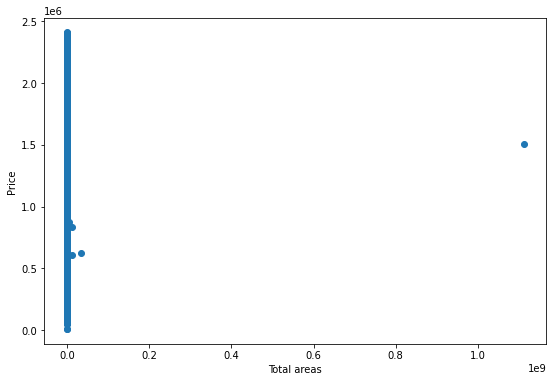

In [155]:
plt.figure(figsize=(9,6))
plt.scatter(df_train['totalAreas'],df_train['pricingInfos.price'])
plt.xlabel('Total areas')
plt.ylabel('Price')
plt.show()

-282.0
376.0


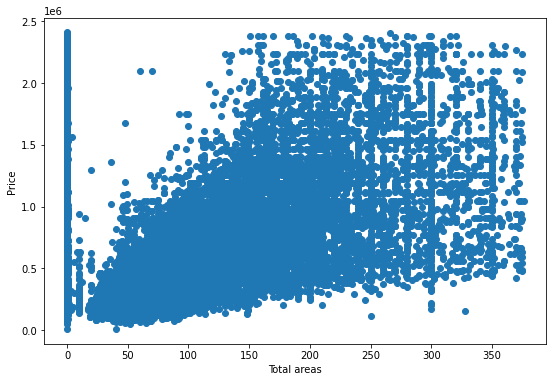

In [156]:
df_train = outlier_detection(df_train, 'totalAreas')

plt.figure(figsize=(9,6))
plt.scatter(df_train['totalAreas'],df_train['pricingInfos.price'])
plt.xlabel('Total areas')
plt.ylabel('Price')
plt.show()

# Feature Engineering

In [157]:
df_train.dtypes

usableAreas                        float64
parkingSpaces                      float64
suites                             float64
bathrooms                          float64
totalAreas                         float64
bedrooms                           float64
address.neighborhood                object
pricingInfos.price                   int64
pricingInfos.yearlyIptu            float64
pricingInfos.monthlyCondoFee       float64
totalAreas_na                        int64
pricingInfos.yearlyIptu_na           int64
pricingInfos.monthlyCondoFee_na      int64
suites_na                            int64
parkingSpaces_na                     int64
usableAreas_na                       int64
bathrooms_na                         int64
dtype: object

In [158]:
le2 = LabelEncoder()
le2.fit(df_train['address.neighborhood'])
df_train['address.neighborhood'] = le2.transform(df_train['address.neighborhood'])
df_train.head()

,usableAreas,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,address.neighborhood,pricingInfos.price,pricingInfos.yearlyIptu,pricingInfos.monthlyCondoFee,totalAreas_na,pricingInfos.yearlyIptu_na,pricingInfos.monthlyCondoFee_na,suites_na,parkingSpaces_na,usableAreas_na,bathrooms_na
0,94.000000,2.000000,0.000000,1.000000,0.000000,3.000000,657,630700,489.000000,"1,120.000000",0,0,0,0,0,0,0
1,141.000000,2.000000,3.000000,4.000000,141.000000,4.000000,4,1106000,0.000000,0.000000,0,0,0,0,0,0,0
2,50.000000,1.000000,0.000000,1.000000,50.000000,2.000000,682,193200,0.000000,322.000000,0,1,0,0,0,0,0
3,64.000000,2.000000,1.000000,2.000000,66.000000,2.000000,27,350000,118.000000,406.000000,0,0,0,0,0,0,0
4,55.000000,1.000000,0.000000,1.000000,55.000000,2.000000,860,252629,644.000000,244.000000,0,0,0,0,0,0,0


### Fazendo algumas conversões de features

In [160]:
for col in df_train.columns:
    if '_na' in col:
        df_train[col] = df_train[col].astype('bool')
for col in df_test.columns:
    if '_na' in col:
        df_test[col] = df_test[col].astype('bool')
        
df_train['pricingInfos.price'] = df_train['pricingInfos.price'].astype('float')

In [161]:
X = df_train.drop(['pricingInfos.price'], axis=1)
y = np.log1p(df_train['pricingInfos.price'].reset_index(drop=True))

# Modelo

### Random Forest

### Utilizando train_test_split para dividir o dataset de treino em teste, e validação.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rfg = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=2, random_state=42)
rfg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, random_state=42)

### Criando função de score para RMSE

In [163]:
def score(y_true, y_pred):
    return str(math.sqrt(mean_squared_error(y_true, y_pred)))

### Calculando score de validação

In [168]:
y_pred = rfg.predict(X_test)
print(score(y_test, y_pred))

0.24734680852321017


### Utilizando grid search para procurar os melhores parâmetros para o random forest

In [169]:
params = {
    'max_depth': [1, 2, 5, 10, 20 ],
    'min_samples_leaf': [10, 20, 50, 100 , 200 , 400],
    'max_features': [4 , 8 , 15 , 20],
    'n_estimators': [10, 30, 50, 100, 200]
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rfg, param_grid=params, 
                          cv=3, n_jobs=-1, verbose=1, scoring = "neg_mean_squared_error")

In [170]:
%%time
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 12.4min finished


CPU times: user 42.2 s, sys: 2.65 s, total: 44.9 s
Wall time: 12min 59s


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [4, 8, 15, 20],
                         'min_samples_leaf': [10, 20, 50, 100, 200, 400],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

### Modelo final

In [171]:
rf_final = grid_search.best_estimator_

In [172]:
rf_final

RandomForestRegressor(max_depth=20, max_features=15, min_samples_leaf=10,
                      n_estimators=200, random_state=42)

In [173]:
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=15, min_samples_leaf=10,
                      n_estimators=200, random_state=42)

In [174]:
y_pred = rf_final.predict(X_test)
print(score(y_test, y_pred))

0.23606440721028923
